In [1]:
import numpy as np 
import pandas as pd
import os 
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import time 
import datetime
from transformers import *
import seaborn as sns

/opt/conda/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
train = pd.read_csv("sample_train.csv")
test = pd.read_csv("test.csv")

In [3]:
code_folder = 'code'
problem_folders = os.listdir(code_folder)

In [4]:
def preprocess_script(script):
    '''
    간단한 전처리 함수
    주석 -> 삭제
    '    '-> tab 변환
    다중 개행 -> 한 번으로 변환
    '''
    with open(script,'r',encoding='utf-8') as file:
        lines = file.readlines()
        preproc_lines = []
        for line in lines:
            if line.lstrip().startswith('#'):
                continue
            line = line.rstrip()
            if '#' in line:
                line = line[:line.index('#')]
            line = line.replace('\n','')
            line = line.replace('    ','\t')
            if line == '':
                continue
            preproc_lines.append(line)
        preprocessed_script = '\n'.join(preproc_lines)
    return preprocessed_script

preproc_scripts = []
problem_nums = []

for problem_folder in tqdm(problem_folders):
    scripts = os.listdir(os.path.join(code_folder,problem_folder))
    problem_num = scripts[0].split('_')[0]
    for script in scripts:
        script_file = os.path.join(code_folder,problem_folder,script)
        preprocessed_script = preprocess_script(script_file)

        preproc_scripts.append(preprocessed_script)
    problem_nums.extend([problem_num]*len(scripts))


100%|██████████| 300/300 [00:09<00:00, 32.36it/s]


In [5]:
import pandas as pd
df = pd.DataFrame(data = {'code':preproc_scripts, 'problem_num':problem_nums})


In [6]:
df.tail(10)

,code,problem_num
45091,"N=int(input())\nS=input()\nans=""""\nfor i in ra...",problem271
45092,N = int(input())\nS = str(input())\nalpha = ['...,problem271
45093,N = int(input())\nS = input()\nchar = ''\nfor ...,problem271
45094,N = int(input())\nS = input()\nret = ''\nfor s...,problem271
45095,N = int(input())\nS = input()\nanswer = []\nfo...,problem271
45096,n = int(input())\nS = input()\na = ord('A')\nz...,problem271
45097,"alphabet = ""ABCDEFGHIJKLMNOPQRSTUVWXYZ""\nn = i...",problem271
45098,N = int(input())\nS = input()\nres = ''\nfor c...,problem271
45099,"import sys, bisect, math, itertools, string, q...",problem271
45100,n = int(input())\ns = input()\nans = ''\nfor i...,problem271


In [8]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
df['tokens'] = df['code'].apply(tokenizer.tokenize)
df['len'] = df['tokens'].apply(len)
df.describe()

loading configuration file https://huggingface.co/microsoft/graphcodebert-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8edef9fb59cf1f2670191d673b13a719a79361a2ae12cc806f942649b8b90db8.62db6c94b05689b7cb238a1a38840e19d1014fc755a9e328ab74a6c672db2d3d
Model config RobertaConfig {
  "_name_or_path": "microsoft/graphcodebert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache":

,len
count,45101.000000
mean,160.123789
std,500.930345
min,5.000000
25%,61.000000
50%,108.000000
75%,200.000000
max,97566.000000


In [9]:
ndf = df[df['len'] <= 512].reset_index(drop=True)
ndf.describe()

,len
count,43647.000000
mean,137.920842
std,104.933475
min,5.000000
25%,60.000000
50%,104.000000
75%,187.000000
max,512.000000


In [10]:
ndf.head()

,code,problem_num,tokens,len
0,import numpy as np\nH = int(input())\nW = int(...,problem236,"[import, Ġn, umpy, Ġas, Ġnp, Ċ, H, Ġ=, Ġint, (...",44
1,"import sys\nread=sys.stdin.read\nh,w,n=map(int...",problem236,"[import, Ġsys, Ċ, read, =, sys, ., std, in, .,...",49
2,x = int(input())\ny = int(input())\nz = int(in...,problem236,"[x, Ġ=, Ġint, (, input, ()), Ċ, y, Ġ=, Ġint, (...",58
3,import sys\nimport math\nimport itertools\nimp...,problem236,"[import, Ġsys, Ċ, import, Ġmath, Ċ, import, Ġi...",177
4,import sys\ninput = sys.stdin.readline\nsys.se...,problem236,"[import, Ġsys, Ċ, input, Ġ=, Ġsys, ., std, in,...",113


In [11]:
from sklearn.model_selection import train_test_split

train_df, valid_df, train_label, valid_label = train_test_split(
        ndf,
        ndf['problem_num'],
        random_state=42,
        test_size=0.1,
        stratify=ndf['problem_num'],
    )

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)


In [ ]:
# 참고: https://dacon.io/competitions/official/235900/codeshare/4907?page=1&dtype=recent 
from rank_bm25 import BM25Okapi
from itertools import combinations
codes = train_df['code'].to_list()
problems = train_df['problem_num'].unique().tolist()
problems.sort()

tokenized_corpus = [tokenizer.tokenize(code) for code in codes]
bm25 = BM25Okapi(tokenized_corpus)

total_positive_pairs = []
total_negative_pairs = []

for problem in tqdm(problems):
    solution_codes = train_df[train_df['problem_num'] == problem]['code']
    positive_pairs = list(combinations(solution_codes.to_list(),2))

    solution_codes_indices = solution_codes.index.to_list()
    negative_pairs = []

    first_tokenized_code = tokenizer.tokenize(positive_pairs[0][0])
    negative_code_scores = bm25.get_scores(first_tokenized_code)
    negative_code_ranking = negative_code_scores.argsort()[::-1] # 내림차순
    ranking_idx = 0
    
    for solution_code in solution_codes:
        negative_solutions = []
        while len(negative_solutions) < len(positive_pairs) // len(solution_codes):
            high_score_idx = negative_code_ranking[ranking_idx]
            
            if high_score_idx not in solution_codes_indices:
                negative_solutions.append(train_df['code'].iloc[high_score_idx])
            ranking_idx += 1

        for negative_solution in negative_solutions:
            negative_pairs.append((solution_code, negative_solution))
    
    total_positive_pairs.extend(positive_pairs)
    total_negative_pairs.extend(negative_pairs)

pos_code1 = list(map(lambda x:x[0],total_positive_pairs))
pos_code2 = list(map(lambda x:x[1],total_positive_pairs))

neg_code1 = list(map(lambda x:x[0],total_negative_pairs))
neg_code2 = list(map(lambda x:x[1],total_negative_pairs))

pos_label = [1]*len(pos_code1)
neg_label = [0]*len(neg_code1)

pos_code1.extend(neg_code1)
total_code1 = pos_code1
pos_code2.extend(neg_code2)
total_code2 = pos_code2
pos_label.extend(neg_label)
total_label = pos_label
pair_data = pd.DataFrame(data={
    'code1':total_code1,
    'code2':total_code2,
    'similar':total_label
})
pair_data = pair_data.sample(frac=1).reset_index(drop=True)

pair_data.to_csv('train_data.csv',index=False)


In [ ]:
pair_data.head()

In [ ]:
pair_data.shape

In [ ]:
sns.countplot(pair_data['similar'])

In [26]:
from rank_bm25 import BM25Okapi
from itertools import combinations
codes = valid_df['code'].to_list()
problems = valid_df['problem_num'].unique().tolist()
problems.sort()

tokenized_corpus = [tokenizer.tokenize(code) for code in codes]
bm25 = BM25Okapi(tokenized_corpus)

total_positive_pairs = []
total_negative_pairs = []

for problem in tqdm(problems):
    solution_codes = valid_df[valid_df['problem_num'] == problem]['code']
    positive_pairs = list(combinations(solution_codes.to_list(),2))

    solution_codes_indices = solution_codes.index.to_list()
    negative_pairs = []

    first_tokenized_code = tokenizer.tokenize(positive_pairs[0][0])
    negative_code_scores = bm25.get_scores(first_tokenized_code)
    negative_code_ranking = negative_code_scores.argsort()[::-1] # 내림차순
    ranking_idx = 0
    
    for solution_code in solution_codes:
        negative_solutions = []
        while len(negative_solutions) < len(positive_pairs) // len(solution_codes):
            high_score_idx = negative_code_ranking[ranking_idx]
            
            if high_score_idx not in solution_codes_indices:
                negative_solutions.append(valid_df['code'].iloc[high_score_idx])
            ranking_idx += 1

        for negative_solution in negative_solutions:
            negative_pairs.append((solution_code, negative_solution))
    
    total_positive_pairs.extend(positive_pairs)
    total_negative_pairs.extend(negative_pairs)

pos_code1 = list(map(lambda x:x[0],total_positive_pairs))
pos_code2 = list(map(lambda x:x[1],total_positive_pairs))

neg_code1 = list(map(lambda x:x[0],total_negative_pairs))
neg_code2 = list(map(lambda x:x[1],total_negative_pairs))

pos_label = [1]*len(pos_code1)
neg_label = [0]*len(neg_code1)

pos_code1.extend(neg_code1)
total_code1 = pos_code1
pos_code2.extend(neg_code2)
total_code2 = pos_code2
pos_label.extend(neg_label)
total_label = pos_label
pair_data = pd.DataFrame(data={
    'code1':total_code1,
    'code2':total_code2,
    'similar':total_label
})
pair_data = pair_data.sample(frac=1).reset_index(drop=True)

pair_data.to_csv('valid_data.csv',index=False)


100%|██████████| 300/300 [00:52<00:00,  5.74it/s]


In [27]:
pair_data.shape

(59731, 3)

/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='similar', ylabel='count'>

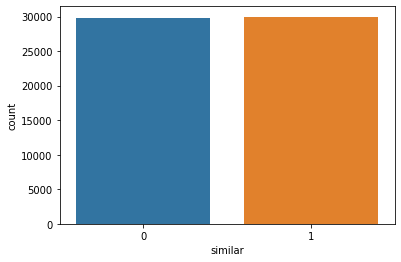

In [28]:
sns.countplot(pair_data['similar'])

In [12]:
train_data = pd.read_csv("train_data.csv") 
valid_data = pd.read_csv("valid_data.csv") 

In [13]:
train_data.head() 

,code1,code2,similar
0,import sys\ndef popcount(x: int):\n\treturn bi...,"def popcnt(n):\n\treturn bin(n).count(""1"")\nde...",1
1,import sys\nfrom sys import exit\nfrom collect...,from collections import deque\ndef main():\n ...,0
2,from _collections import deque\nfrom _ast impo...,"t1,t2=map(int,input().split())\na1,a2=map(int,...",1
3,N = int(input())\nd = [0] * N\nc = 0\nb = True...,import sys\nn=int(input())\nd=[]\ncnt=0\nfor i...,1
4,import sys\nimport math\nimport time\nreadline...,import math\nfrom functools import reduce\nK =...,1


In [14]:
valid_data.head() 

,code1,code2,similar
0,"X,N=map(int,input().split())\nP=set(map(int,in...","X,N = (int(x) for x in input().split())\np = s...",1
1,import math\nr = float(input())\nprint('%.6f %...,"def main(X, Y):\n\tfor n_crane in range(X + 1)...",0
2,"import math\nn,m,x = map(int,input().split())\...","n, k = map(int, input().split())\np = list(map...",0
3,"h, w = list(map(int, input().split()))\nmasu =...","a, b = map(int,input().split())\nn = a*b\nif a...",1
4,import sys\nimport os\ndef file_input():\n\tf ...,"def cmb(n, r, p):\n\tif (r < 0) or (n < r):\n\...",0


In [15]:
train_data.shape, valid_data.shape

((5159810, 3), (59731, 3))

# Train + Validation

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/graphcodebert-base") 
model.cuda() 

loading configuration file https://huggingface.co/microsoft/graphcodebert-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8edef9fb59cf1f2670191d673b13a719a79361a2ae12cc806f942649b8b90db8.62db6c94b05689b7cb238a1a38840e19d1014fc755a9e328ab74a6c672db2d3d
Model config RobertaConfig {
  "_name_or_path": "microsoft/graphcodebert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache":

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

storing https://huggingface.co/microsoft/graphcodebert-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/790fa523a045ef75a0bb2c78f19ccb8531275871a4a2a88b524292725e0e65c8.459848ee0fb5942db5cb70ab4db4066013ff7b1f52071fc5e5792f691a813b6c
creating metadata file for /root/.cache/huggingface/transformers/790fa523a045ef75a0bb2c78f19ccb8531275871a4a2a88b524292725e0e65c8.459848ee0fb5942db5cb70ab4db4066013ff7b1f52071fc5e5792f691a813b6c
loading weights file https://huggingface.co/microsoft/graphcodebert-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/790fa523a045ef75a0bb2c78f19ccb8531275871a4a2a88b524292725e0e65c8.459848ee0fb5942db5cb70ab4db4066013ff7b1f52071fc5e5792f691a813b6c
Some weights of the model checkpoint at microsoft/graphcodebert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.b

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [17]:
c1 = train_data['code1'].values 
c2 = train_data['code2'].values 
similar = train_data['similar']

N = train_data.shape[0] 
MAX_LEN = 512 

input_ids = np.zeros((N, MAX_LEN),dtype=int)
attention_masks = np.zeros((N, MAX_LEN),dtype=int)
labels = np.zeros((N),dtype=int)

for i in tqdm(range(N), position=0, leave=True): 
    try:
        cur_c1 = c1[i] 
        cur_c2 = c2[i]
        encoded_input = tokenizer(cur_c1, cur_c2, return_tensors='pt', max_length=512, padding='max_length', truncation=True) 
        input_ids[i,] = encoded_input['input_ids'] 
        attention_masks[i,] = encoded_input['attention_mask'] 
        labels[i] = similar[i] 
    except Exception as e: 
        print(e)
        pass
         


100%|██████████| 5159810/5159810 [1:42:43<00:00, 837.09it/s]  


In [18]:
import telegram
tel_token = "5059732158:AAE87TaReNbDKH3_Fy-CAYCUuIO2qiUyK2I"
chat_id = 1720119057 
bot = telegram.Bot(token=tel_token)

bot.sendMessage(chat_id=chat_id, text="train preprocessing done!")

In [19]:
c1 = valid_data['code1'].values 
c2 = valid_data['code2'].values 
similar = valid_data['similar']

N = valid_data.shape[0] 
MAX_LEN = 512 

valid_input_ids = np.zeros((N, MAX_LEN),dtype=int)
valid_attention_masks = np.zeros((N, MAX_LEN),dtype=int)
valid_labels = np.zeros((N),dtype=int)

for i in tqdm(range(N), position=0, leave=True): 
    try:
        cur_c1 = c1[i] 
        cur_c2 = c2[i]
        encoded_input = tokenizer(cur_c1, cur_c2, return_tensors='pt', max_length=512, padding='max_length', truncation=True) 
        valid_input_ids[i,] = encoded_input['input_ids'] 
        valid_attention_masks[i,] = encoded_input['attention_mask'] 
        valid_labels[i] = similar[i] 
    except Exception as e: 
        print(e)
        pass
         


100%|██████████| 59731/59731 [01:09<00:00, 860.76it/s]


In [20]:
input_ids = torch.tensor(input_ids, dtype=int)
attention_masks = torch.tensor(attention_masks, dtype=int)
labels = torch.tensor(labels, dtype=int)

valid_input_ids = torch.tensor(valid_input_ids, dtype=int)
valid_attention_masks = torch.tensor(valid_attention_masks, dtype=int) 
valid_labels = torch.tensor(valid_labels, dtype=int)  

input_ids.shape, attention_masks.shape, labels.shape, valid_input_ids.shape, valid_attention_masks.shape, valid_labels.shape

(torch.Size([5159810, 512]),
 torch.Size([5159810, 512]),
 torch.Size([5159810]),
 torch.Size([59731, 512]),
 torch.Size([59731, 512]),
 torch.Size([59731]))

In [21]:
torch.save(input_ids, 'train_input_ids.pt')
torch.save(attention_masks, 'train_attention_masks.pt')
torch.save(labels, "train_labels.pt") 

torch.save(valid_input_ids, "valid_input_ids.pt") 
torch.save(valid_attention_masks, "valid_attention_masks.pt") 
torch.save(valid_labels, "valid_labels.pt")

In [22]:
input_ids = torch.load('train_input_ids.pt') 
attention_masks = torch.load('train_attention_masks.pt') 
labels = torch.load('train_labels.pt') 

valid_input_ids = torch.load('valid_input_ids.pt') 
valid_attention_masks = torch.load('valid_attention_masks.pt') 
valid_labels = torch.load('valid_labels.pt') 

In [23]:
batch_size = 32
train_data = TensorDataset(input_ids, attention_masks, labels) 
train_sampler = RandomSampler(train_data) 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) 

validation_data = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels) 
validation_sampler = SequentialSampler(validation_data) 
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [24]:
model = AutoModelForSequenceClassification.from_pretrained("microsoft/graphcodebert-base") 
model.cuda() 

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 10

total_steps = len(train_dataloader) * epochs 

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps) 

def flat_accuracy(preds, labels): 
    pred_flat = np.argmax(preds, axis=1).flatten() 
    labels_flat = labels.flatten() 
    return np.sum(pred_flat == labels_flat) / len(labels_flat) 

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


device = torch.device("cuda")
loss_f = nn.CrossEntropyLoss() 

loading configuration file https://huggingface.co/microsoft/graphcodebert-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8edef9fb59cf1f2670191d673b13a719a79361a2ae12cc806f942649b8b90db8.62db6c94b05689b7cb238a1a38840e19d1014fc755a9e328ab74a6c672db2d3d
Model config RobertaConfig {
  "_name_or_path": "microsoft/graphcodebert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache":

In [25]:
train_losses, train_accuracies = [], [] 
val_losses, val_accuracies = [], []
model.zero_grad() 
for i in range(epochs): 
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))
    print('Training...')
    t0 = time.time() 
    train_loss, train_accuracy = 0, 0 
    model.train() 
    for step, batch in tqdm(enumerate(train_dataloader), desc="Iteration", smoothing=0.05): 
        if step % 10000 == 0 and not step == 0: 
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            print('  current average loss = {}'.format(train_loss / step)) 
            bot.sendMessage(chat_id=chat_id, text = '  current average loss = {}'.format(train_loss / step))
       
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        loss = outputs[0]
        logits = outputs[1] 
        train_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.detach().cpu().numpy() 
        train_accuracy += flat_accuracy(logits, label_ids)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()
    avg_train_loss = train_loss / len(train_dataloader)  
    avg_train_accuracy = train_accuracy / len(train_dataloader)
    train_losses.append(avg_train_loss) 
    train_accuracies.append(avg_train_accuracy) 
    print("  Average training loss: {0:.8f}".format(avg_train_loss))
    print("  Average training accuracy: {0:.8f}".format(avg_train_accuracy))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    
    print("")
    print("Validating...") 
    t0 = time.time() 
    model.eval() 
    val_loss, val_accuracy = 0, 0 
    for step, batch in tqdm(enumerate(validation_dataloader), desc="Iteration", smoothing=0.05):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch 
        with torch.no_grad():     
            outputs = model(b_input_ids, 
                            attention_mask=b_input_mask)
        logits = outputs[0] 
        logits = logits.detach().cpu() 
        label_ids = b_labels.detach().cpu() 
        val_loss += loss_f(logits, label_ids)
        
        logits = logits.numpy() 
        label_ids = label_ids.numpy() 
        val_accuracy += flat_accuracy(logits, label_ids) 
        
    avg_val_accuracy = val_accuracy / len(validation_dataloader)  
    avg_val_loss = val_loss / len(validation_dataloader) 
    val_accuracies.append(avg_val_accuracy)
    val_losses.append(avg_val_loss)
    print("  Average validation loss: {0:.8f}".format(avg_val_loss))
    print("  Average validation accuracy: {0:.8f}".format(avg_val_accuracy))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    bot.sendMessage(chat_id=chat_id, text="Epoch {} Done!".format(i+1))   
    bot.sendMessage(chat_id=chat_id, text="avg validation loss = {}".format(avg_val_loss)) 
    bot.sendMessage(chat_id=chat_id, text="avg validation accuracy = {}%".format(avg_val_accuracy)) 
    
    if np.min(val_losses) == val_losses[-1]:
        print("saving current best checkpoint") 
        torch.save(model.state_dict(), "graphcodebert-base.pt") 
    
        


======== Epoch 1 / 10 ========
Training...


Iteration: 10000it [2:43:57,  1.03it/s]

  Batch 10,000  of  161,245.    Elapsed: 2:43:57.
  current average loss = 0.09112094516304496


Iteration: 20000it [5:28:12,  1.01it/s]

  Batch 20,000  of  161,245.    Elapsed: 5:28:13.
  current average loss = 0.06711813350437587


Iteration: 21274it [5:49:11,  1.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration: 30000it [8:12:20,  1.02it/s]

  Batch 30,000  of  161,245.    Elapsed: 8:12:21.
  current average loss = 0.055172500686507316


Iteration: 50000it [13:40:44,  1.02it/s]

  Batch 50,000  of  161,245.    Elapsed: 13:40:45.
  current average loss = 0.04296189216297636


Iteration: 54373it [14:52:42,  1.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iteration: 60000it [16:25:28,  1.01it/s]

  Batch 60,000  of  161,245.    Elapsed: 16:25:28.
  current average loss = 0.03911556286762922


Iteration: 60000it [16:26:08,  1.01it/s]


NetworkError: urllib3 HTTPError HTTPSConnectionPool(host='api.telegram.org', port=443): Max retries exceeded with url: /bot5059732158:AAE87TaReNbDKH3_Fy-CAYCUuIO2qiUyK2I/sendMessage (Caused by NewConnectionError('<telegram.vendor.ptb_urllib3.urllib3.connection.VerifiedHTTPSConnection object at 0x7f53bbb2c1d0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))

# Inference

In [ ]:
# inference 
checkpoint = torch.load("graphcodebert-base.pt")
test_model = AutoModelForSequenceClassification.from_pretrained("microsoft/graphcodebert-base")  
test_model.load_state_dict(checkpoint) 
test_model.cuda() 
test_model.eval() 

test_c1 = test['code1'].values 
test_c2 = test['code2'].values 
m = nn.Sigmoid() 
pred_classes = []
for i in tqdm(range(len(test_c1))):
    encoded_input = tokenizer(test_c1[i], test_c2[i], return_tensors='pt', max_length=512, padding='max_length', truncation=True).to(device)
    input_id = encoded_input['input_ids'][0]
    attention_mask = encoded_input['attention_mask'][0]
    
    with torch.no_grad(): 
        output = model(**encoded_input)
    logits = output['logits'] 
    probs = m(logits) 
    probs = probs.detach().cpu().numpy() 
    pred_class = np.argmax(probs, axis=1)[0]
    pred_classes.append(pred_class)
    
    
ss = pd.read_csv("sample_submission.csv") 
ss['similar'] = pred_classes 
ss.to_csv("graphcodebert_finetuned.csv",index=False)


bot.sendMessage(chat_id = chat_id, text = "Testing Done!") 

